Learn the inter-grid kernels for homogeneous problems using multigrid framework, dataset is constructed by changing RHS 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class RHSDataSet(Dataset):
    def __init__(self, h5file, case='train', transform=None, target_transform=None):
        """
        case = 'train' or 'test'
        """
        h5 = h5py.File(h5file,'r')
        self.data = np.array(h5[case], dtype=np.float32)
        self.totensor = ToTensor()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        rhs_tensor = self.totensor(self.data[idx])
        if self.transform:
            rhs_tensor = self.transform(rhs_tensor)
        return rhs_tensor

In [3]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [4]:
#for i, data in enumerate(train_dataloader):
#    img = data
#    print(img.shape)

In [90]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 1] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [93]:
class TwoGrid(nn.Module):
    '''Define the two-grid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(TwoGrid, self).__init__()

        # Hyper parameters
        self.m = 10 # number of iterations to compute q

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = 2 # two-grid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Kernels for inter-grid communication 
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0
        self.conv.weight = nn.Parameter(restriction_kernel.reshape(1,1,3,3))
        self.conv.requires_grad_(False)

        self.deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        interpolation_kernel = torch.asarray([[1, 2, 1],
                                              [2, 4, 2],
                                              [1, 2, 1]], dtype=torch.float32) / 4.0
        interpolation_kernel = interpolation_kernel #+ torch.randn((3,3))
        self.deconv.weight = nn.Parameter(interpolation_kernel.reshape(1,1,3,3))
        # self.deconv.requires_grad_(True)
        self.deconv.requires_grad_(False)

        self.w = torch.asarray([4.,1.], dtype=torch.float32)
        self.w.requires_grad_(True)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, x):
        "Compute the convergence factor after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.m))
    
    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        U = torch.clone(self.v)
    
        for i in range(self.m-1):
            U = self.iterate(U).detach()
        return self.iterate(U)

    def iterate(self, x):
        n_batches = x.shape[0]
        v1, v2, v3 = [1, 1, 1] # number of relaxations
        xF = self.grids[0].Relax(x, self.f, v1)
        rF = self.f-self.grids[0].Knet(xF) # residual on fine grid
        rC = self.w[0]*self.Restrict(rF)
        xC = torch.zeros((n_batches,1,int(self.n/2)+1,int(self.n/2)+1), dtype=torch.float32, requires_grad=False)
        eC = self.grids[1].Relax(xC, rC, v2) # solve for the coarse-grid error
        error_delta = self.w[1]*self.Interpolate(eC)
        xF = xF + error_delta
        x = self.grids[0].Relax(xF, self.f, v3)
        return x

In [94]:
n = 2**4
model = TwoGrid(n)
rhs = next(iter(train_dataloader))

0 0.1575048565864563
1 0.09678207337856293
2 0.06656261533498764
3 0.0485876090824604
4 0.03701263293623924
5 0.029161939397454262
6 0.023613451048731804
7 0.019549913704395294
8 0.01647687517106533
9 0.0140836825594306
10 0.012170050293207169
11 0.010604034177958965
12 0.009297111071646214
13 0.00818885862827301
14 0.007237045560032129
15 0.006411542184650898
16 0.005690275691449642
17 0.005056563764810562
18 0.004497546702623367
19 0.004002958070486784
20 0.003564417129382491
21 0.003174991114065051
22 0.002828786848112941
23 0.0025207563303411007
24 0.0022465453948825598
25 0.0020023477263748646
26 0.0017847742419689894
27 0.0015909323701635003
28 0.0014181823935359716
29 0.0012642209185287356
30 0.0011269936803728342
31 0.0010046742390841246
32 0.0008956336532719433
33 0.0007984404801391065
34 0.0007117657805792987
35 0.0006345428409986198
36 0.0005656885332427919
37 0.0005042995908297598
38 0.00044956622878089547
39 0.0004007842799182981
40 0.0003572965506464243
41 0.0003185291716

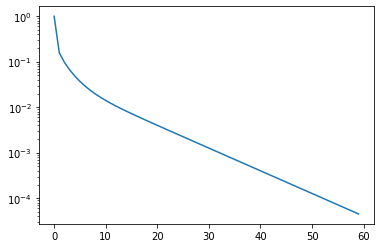

In [95]:
EPS = 5e-5
n_twogrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "two-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [96]:
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.deconv.weight
optimizer = torch.optim.Adam([model.w], lr=1e-3)
model.w

tensor([4., 1.], requires_grad=True)

In [97]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        optimizer.step()
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [98]:
model_dir = 'Model/twogrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

num_epoch = 200
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_twogrid_poisson.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

print("\nNew value:")
model.conv.weight
model.deconv.weight
model.w

0 0.7268001288175583
1 0.7239741235971451
2 0.7223949246108532
3 0.7213919460773468
4 0.7187411673367023
5 0.7173985801637173
6 0.7156198732554913
7 0.7139395885169506
8 0.7124300301074982
9 0.7100181579589844
10 0.7075861431658268
11 0.706714253872633
12 0.70445691421628
13 0.7021414116024971
14 0.7011432461440563
15 0.6978616751730442
16 0.6965348310768604
17 0.6952684037387371
18 0.6941705346107483
19 0.6912054643034935
20 0.6896312721073627
21 0.6876190006732941
22 0.6863714717328548
23 0.6828834041953087
24 0.6825345680117607
25 0.6801986545324326
26 0.6780063509941101
27 0.6760173700749874
28 0.6746950000524521
29 0.6731093898415565
30 0.6705913841724396
31 0.6675675921142101
32 0.6660148426890373
33 0.6630821973085403
34 0.6630574390292168
35 0.658860269933939
36 0.657372135668993
37 0.6563094519078732
38 0.6528336778283119
39 0.6513513922691345
40 0.6494031809270382
41 0.6467447839677334
42 0.6457336507737637
43 0.6435634419322014
44 0.6391511559486389
45 0.6381571926176548
46 

Parameter containing:
tensor([[[[0.2500, 0.5000, 0.2500],
          [0.5000, 1.0000, 0.5000],
          [0.2500, 0.5000, 0.2500]]]])

Text(0.5, 0, 'epoch')

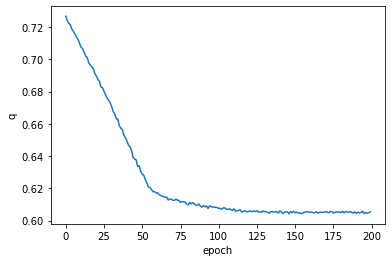

In [99]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [101]:
EPS = 5e-5
n_twogrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "two-grid iterations ")

0 0.10750744491815567
1 0.046925462782382965
2 0.02541257068514824
3 0.01509382389485836
4 0.00971422903239727
5 0.006587232928723097
6 0.0046157208271324635
7 0.0032951715402305126
8 0.0023768553510308266
9 0.0017240983434021473
10 0.0012544059427455068
11 0.000914171920157969
12 0.0006668122950941324
13 0.00048663438064977527
14 0.0003552338748704642
15 0.0002593475510366261
16 0.00018937114509753883
17 0.0001382794725941494
18 0.00010097127233166248
19 7.373841071967036e-05
20 5.38407766725868e-05
21 3.930967068299651e-05
Solution converges after 22 two-grid iterations 


In [104]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        # Problem parameters
        C = 0.0
        k = 1
        l = 2

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = [4,1] #inter_model.w.detach()
        self.restrict_kernel = inter_model.conv.weight.detach()
        self.interpolate_kernel = inter_model.deconv.weight.detach()
        
        u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)  # exact solution
        self.u_exact = torch.from_numpy(u_exact.reshape(1,1,n+1, n+1))

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = C*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        #f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        #v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        return v

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.w[1]*self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.randn((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

9.033153871554534 3.4255433082580566
3.980251977600249 0.6328164339065552
3.5389720195054712 0.13770125806331635
3.4025417836288874 0.03119516186416149
3.3287798289089268 0.007194072473794222
3.2777630349514406 0.0016783055616542697
3.238660027356893 0.0003949177043978125
3.207138293771732 9.356163354823366e-05
3.181035504465467 2.2289146727416664e-05
Solution converges after 9 V-cycle iterations with relative error of 3.181035504465467


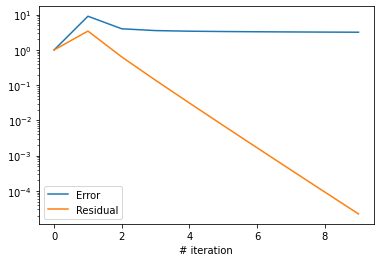

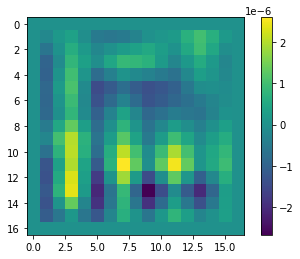

In [105]:
# Multigrid implementation
n = 2**4
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())